<a href="https://colab.research.google.com/github/sayakpaul/SimCLR-in-TensorFlow-2/blob/master/Backbone_Arch_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gather dataset

In [0]:
!touch stl10_input.py

In [0]:
!python stl10_input.py

## Imports

In [0]:
from imutils import paths
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import numpy as np

np.random.seed(0)

## Data preview

In [0]:
!sudo apt-get install tree

In [171]:
!tree --filelimit 20 train

train
├── 1 [500 entries exceeds filelimit, not opening dir]
├── 10 [500 entries exceeds filelimit, not opening dir]
├── 2 [500 entries exceeds filelimit, not opening dir]
├── 3 [500 entries exceeds filelimit, not opening dir]
├── 4 [500 entries exceeds filelimit, not opening dir]
├── 5 [500 entries exceeds filelimit, not opening dir]
├── 6 [500 entries exceeds filelimit, not opening dir]
├── 7 [500 entries exceeds filelimit, not opening dir]
├── 8 [500 entries exceeds filelimit, not opening dir]
└── 9 [500 entries exceeds filelimit, not opening dir]

10 directories, 0 files


In [172]:
!tree --filelimit 20 test

test
├── 1 [800 entries exceeds filelimit, not opening dir]
├── 10 [800 entries exceeds filelimit, not opening dir]
├── 2 [800 entries exceeds filelimit, not opening dir]
├── 3 [800 entries exceeds filelimit, not opening dir]
├── 4 [800 entries exceeds filelimit, not opening dir]
├── 5 [800 entries exceeds filelimit, not opening dir]
├── 6 [800 entries exceeds filelimit, not opening dir]
├── 7 [800 entries exceeds filelimit, not opening dir]
├── 8 [800 entries exceeds filelimit, not opening dir]
└── 9 [800 entries exceeds filelimit, not opening dir]

10 directories, 0 files


In [173]:
!tree --filelimit 20 unlabeled

unlabeled [100000 entries exceeds filelimit, not opening dir]

0 directories, 0 files


In [0]:
train_images = list(paths.list_images("train"))

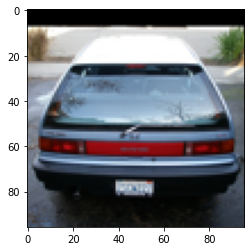

In [142]:
idx = np.random.choice(len(train_images), 1)
sample_training_image = train_images[int(idx)]
image = plt.imread(sample_training_image)
plt.imshow(image)
plt.show()

## Building the data augmentation pipeline

In [0]:
# Reference: https://github.com/sthalles/SimCLR/blob/master/data_aug/gaussian_blur.py
class GaussianBlur(object):
    # Implements Gaussian blur as described in the SimCLR paper
    def __init__(self, kernel_size=int(0.1 * 96), min=0.1, max=2.0):
        self.min = min
        self.max = max
        # kernel size is set to be 10% of the image height/width
        self.kernel_size = kernel_size

    def __call__(self, sample):
        sample = sample.numpy()
        sample = sample.squeeze(0)

        # blur the image with a 50% chance
        prob = np.random.random_sample()

        if prob < 0.5:
            sigma = (self.max - self.min) * np.random.random_sample() + self.min
            sample = cv2.GaussianBlur(sample, (self.kernel_size, self.kernel_size), sigma)

        return tf.convert_to_tensor(np.expand_dims(sample, 0))

In [0]:
class CustomAugment(object):
	def __call__(self, sample):
		if np.random.random_sample() >= 0.5:
			h = np.random.choice(tf.shape(sample)[1].numpy(), 1) 
			w = np.random.choice(tf.shape(sample)[2].numpy(), 1)
			sample = tf.image.random_crop(sample, [1, int(h), int(w), 3])
			sample = tf.image.resize(sample, size=[96, 96])
		
		if np.random.random_sample() >= 0.5:
			sample = tf.image.flip_left_right(sample)
		
		if np.random.random_sample() >= 0.6:
			sample = self._color_jitter(sample)

		if np.random.random_sample() >= 0.2:
			sample = self._gray_scale(sample)

		return sample

	def _color_jitter(self, sample):
		sample = tf.image.random_brightness(sample, max_delta=0.5)
		sample = tf.image.random_contrast(sample, lower=0.01, upper=0.08)
		sample = tf.image.random_saturation(sample, lower=0.01, upper=0.08)
		sample = tf.image.random_hue(sample, max_delta=0.05)

		return sample

	def _gray_scale(self, sample):
		img2 = np.zeros_like(sample.numpy().squeeze(0))
		sample = tf.image.rgb_to_grayscale(sample)
		temp_sample = sample.numpy().squeeze()
		img2[:,:,0] = temp_sample
		img2[:,:,1] = temp_sample
		img2[:,:,2] = temp_sample

		new_sample = tf.convert_to_tensor(np.expand_dims(img2, 0))

		return new_sample

In [0]:
data_augmentation = keras.Sequential([
    layers.Lambda(CustomAugment()),
    layers.Lambda(GaussianBlur())
])

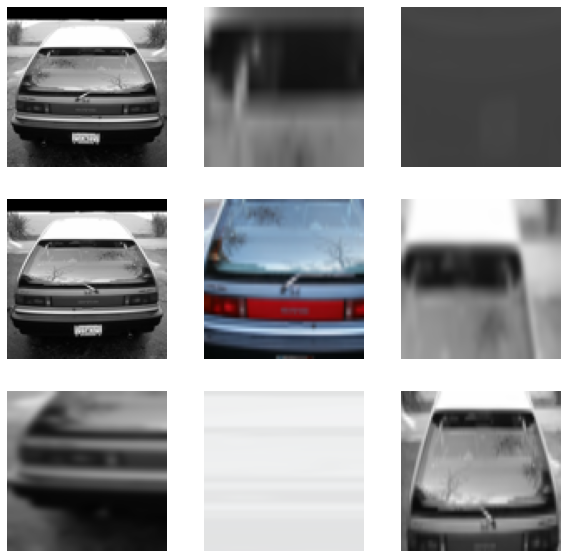

In [185]:
image = plt.imread(sample_training_image)
image = tf.image.convert_image_dtype(image, tf.float32)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(image, 0), training=True)
    plt.imshow(augmented_image[0].numpy())
    plt.axis('off')

## CNN backbone

In [0]:
base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(96, 96, 3))

In [191]:
base_model.layers[-1].output, base_model.trainable

(<tf.Tensor 'conv5_block3_out_2/Identity:0' shape=(None, 3, 3, 2048) dtype=float32>,
 True)

In [193]:
inputs = layers.Input((96, 96, 3))
h = base_model(inputs, training=True)
h = keras.layers.GlobalAveragePooling2D()(h)

projection_1 = keras.layers.Dense(512, activation="relu")(h)
projection_2 = keras.layers.Dense(256)(projection_1)

resnet_simclr = keras.Model(inputs, projection_2)

resnet_simclr.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
resnet50 (Model)             (None, 3, 3, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
Total params: 24,768,128
Trainable params: 24,715,008
Non-trainable params: 53,120
_________________________________________________________________
